# When to plan my kite/surf trip to Washington's West Coast

Here I'll look at the average wind conditions to determine when I'll have the best chance of finding good kiting winds.

While model climatologies exist for the region, observations are more accurate and available. Here we will use 
- Station WPTW1 - 9441102 - Westport, WA for our wind conditions [link](https://www.ndbc.noaa.gov/station_history.php?station=wptw1)
- Grays Harbor - for our wave conditions

NOAA API, https://api.tidesandcurrents.noaa.gov/api/prod/#products

Measure of goodness. The ideal kite-day 
- has 4+ hours of wind consistently between 15-20 mph during daylight hours. 
- gusts are minimal, and the variance in wind speed is low.
- Direction is cross-shore. For surfing goofy, direction is from S

Metrics
- daytime: constrained to 8a-7p PDT (Use -7 hours from GMT)
- speed bins: (10-15, 15-20, 20-25, 25+) mph
- 
- Gustiness
- Daily wind variance
- hours wind speed in range (10-15, 15-20, 20-25, 25+)

Plots
- Year-over-Year wind speeds for a given month

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Non-standard library for NOAA API
import noaa_coops as nc
from calendar import monthrange

In [184]:
def number_of_days_in_month(year=2019, month=2):
    return monthrange(year, month)[1]

import datetime
import calendar

def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.datetime(year, month, day)

In [7]:
%%time
west_port = nc.Station('9441102')
wind = west_port.get_data(
    begin_date="20080101",
    end_date="20220101",
    product="wind",
    bin_num=2,
    units="metric",
    time_zone="gmt",
)
# 5 minutes

CPU times: user 2min 25s, sys: 6.76 s, total: 2min 32s
Wall time: 4min 47s


In [20]:
# Save for faster loading
fname = '../offline_data/west_port_winds.h5'
wind.to_hdf(fname, key='wind', mode='w')  

In [17]:
#900,000 records
sum(~np.isnan(wind.spd))

935750

In [16]:
# Wow, 6-min data
wind.tail(10)

,spd,dir,compass,gust_spd,flags
date_time,,,,,
2022-01-01 23:00:00,4.7,166.0,SSE,8.5,"0,0"
2022-01-01 23:06:00,5.0,166.0,SSE,9.1,"0,0"
2022-01-01 23:12:00,4.2,173.0,S,7.8,"0,0"
2022-01-01 23:18:00,3.8,168.0,SSE,8.4,"0,0"
2022-01-01 23:24:00,3.1,160.0,SSE,6.3,"0,0"
2022-01-01 23:30:00,4.5,162.0,SSE,6.2,"0,0"
2022-01-01 23:36:00,5.3,163.0,SSE,7.7,"0,0"
2022-01-01 23:42:00,5.2,157.0,SSE,7.3,"0,0"
2022-01-01 23:48:00,4.2,155.0,SSE,8.6,"0,0"


In [38]:
wind['spd'] = wind['spd']*2.23694

In [293]:
wind['gust_spd'] = wind['gust_spd']*2.23694

In [195]:

def calc_speed_distr_by_month(wind, mon, bins, years):
    
    histn = np.zeros((len(bins)-1, len(years)))
    
    for i,y in enumerate(years):
        #temp = wind['spd'][(wind.index > pd.Timestamp(y,mon,1)) & (wind.index < pd.Timestamp(y,mon+1,1))]
        temp = wind['spd'][(wind.index > datetime.datetime(y,mon,1)) & (wind.index < add_months(datetime.datetime(y,mon,1), 1))]        
        temp = temp[~np.isnan(temp)]
        Ndays = len(temp) / (10*24)
        hist = np.histogram(temp, bins=bins)
        histn[:,i] = hist[0] / 10 / Ndays   
        
    histn = histn.transpose()     
    
    df = pd.DataFrame(histn, columns=bins[1:] , index=years)
    
    return df


mon = 1
df = calc_speed_distr_by_month(wind, mon, bins, years)
df['month'] = mon
for mon in np.arange(1,13):
    df_temp = calc_speed_distr_by_month(wind, mon, bins, years)
    df_temp['month'] = mon
    df = pd.concat((df, df_temp), axis=0)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [196]:
df

,2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0,22.5,25.0,27.5,30.0,month
2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2009,0.609656,1.369331,2.023673,2.914217,3.188722,3.067429,2.668440,2.429046,2.033249,1.337412,1.235271,0.593696,1
2010,1.350851,1.744999,2.307554,2.755449,3.740818,4.278292,3.318005,1.967154,0.992535,0.662884,0.451478,0.218573,1
2011,0.709112,2.296771,2.980782,3.009021,2.814486,3.727546,3.533011,2.312459,1.396261,0.718525,0.332592,0.138057,1
2012,0.247197,0.913690,2.412516,3.595306,3.582790,3.035202,2.587744,2.475098,2.037027,1.245372,0.801043,0.560104,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,0.465686,1.575205,2.231541,2.928506,2.962886,3.284803,3.272301,2.875374,2.172158,1.365803,0.531319,0.206277,12
2018,0.545954,1.007190,2.124199,2.983919,3.360439,3.617728,2.864688,2.419140,1.763368,1.277030,0.928749,0.533403,12
2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
2020,0.185936,0.638856,1.587604,2.779499,3.475566,3.876043,3.585221,2.564958,1.716329,1.311085,0.905840,0.553039,12


In [187]:
(wind.index > datetime.datetime(y,mon,1))

array([False, False, False, ...,  True,  True,  True])

In [158]:
month_strs = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


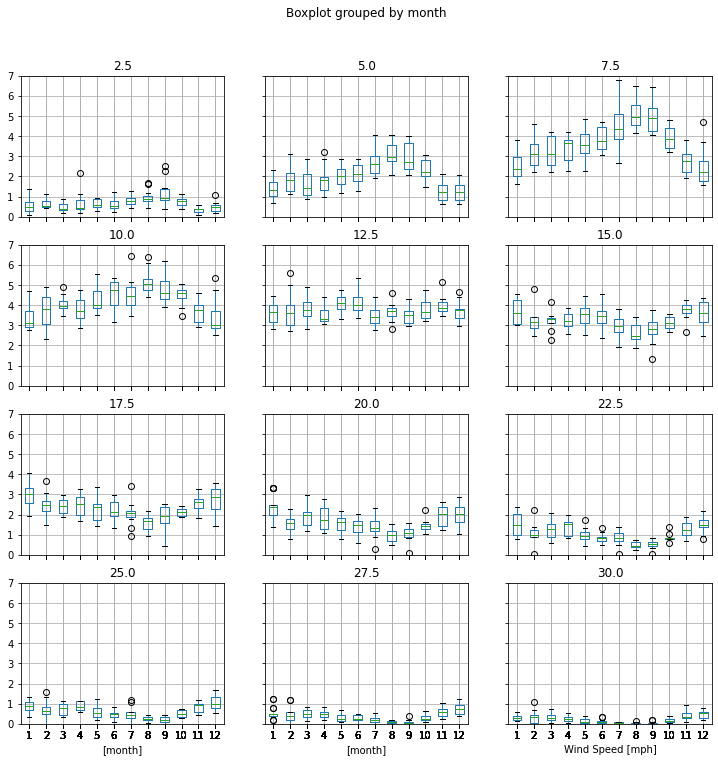

In [200]:

bins = np.arange(0,31,2.5)
years = np.arange(2008, 2022)

mon = 1
#df = calc_speed_distr_by_month(wind, mon, bins, years)
df.boxplot(by='month', figsize=(12,12))

#plt.xlabel('Wind Speed [mph]')    
#plt.ylabel('Average Hours per day')
plt.ylim([0, 7])
plt.show()

In [420]:
def circular_mean(md):
    mdr = np.deg2rad(md)
    u = np.cos(mdr)
    v = np.sin(mdr)
    um = np.mean(u)
    vm = np.mean(v)
    mdm = np.arctan2(vm,um)
    mdm = np.rad2deg(mdm)
    return mdm


In [421]:
%%time
# Improve with: sunset/sunrise calc, proper direct avg, continuous wind, 
# Define if day is kiteable for all days in record, boolean. Then groupby
wind['time_pdt'] = wind.index - datetime.timedelta(hours=7)
days = np.arange(wind.index[0],wind.index[-1], dtype='datetime64[D]')
hours_windy = np.zeros(days.shape)
hours_foil = np.zeros(days.shape)
gust_ratio = np.zeros(days.shape)
mean_dir = np.zeros(days.shape)
wind_std = np.zeros(days.shape)
for i,d in enumerate(days): #[2000:2001]: (for testing)
    morning = d + np.timedelta64(8,'h') #8am
    evening = d + np.timedelta64(19,'h') #7pm   
    I = (wind['time_pdt'] >= morning) & (wind['time_pdt'] <= evening)
    wspd = wind['spd'][I]
    wdir = wind['dir'][I]
    wgst = wind['gust_spd'][I]
    I_windy = (wspd >= 12) & (wspd <= 25) & (wdir > 160) & (wdir < 360)
    hours_windy[i] = np.sum(I_windy) / 10
    if hours_windy[i] > 0:
        hours_foil[i] = np.sum( (wspd >= 8) & (wspd <= 15) & (wdir > 160) & (wdir < 360) ) / 10
        gust_ratio[i] = np.mean( wgst[I_windy] / wspd[I_windy])
        mean_dir[i] = circular_mean(wdir[I_windy])
        wind_std[i] = np.std(wspd[I_windy])
    else:
        gust_ratio[i] = np.nan
        wind_std[i] = np.nan
        mean_dir[i] = np.nan

CPU times: user 55.6 s, sys: 844 ms, total: 56.4 s
Wall time: 59.4 s


In [423]:
dfd = pd.DataFrame({'day':days, 'hours_windy':hours_windy, 
                    'hours_foil':hours_foil, 
                    'gust_ratio':gust_ratio,
                    'mean_dir':mean_dir,
                    'wind_std':wind_std})

In [424]:
dfd['kite'] = (dfd['hours_windy'] > 4)

In [425]:
dfd['month'] = [x.month for x in dfd['day']]

In [426]:
dfd.groupby('month').mean()

,hours_windy,hours_foil,gust_ratio,mean_dir,wind_std,kite
month,,,,,,
1,2.011414,1.245161,1.344319,-69.775743,2.059516,0.225806
2,1.828610,1.301362,1.283863,-76.369473,1.937510,0.185286
3,3.224566,2.306203,1.289087,-84.160229,1.901762,0.347395
4,4.119231,3.055897,1.243161,-80.950282,1.930578,0.474359
5,4.105955,3.774690,1.197946,-69.635125,1.780378,0.478908
6,3.823261,3.815108,1.189421,-71.506308,1.667930,0.434053
7,3.572811,3.082949,1.177436,-56.735104,1.800068,0.403226
8,2.735714,3.425806,1.181416,-66.593845,1.592484,0.311060
9,2.718571,2.690476,1.226306,-76.375655,1.638052,0.354762


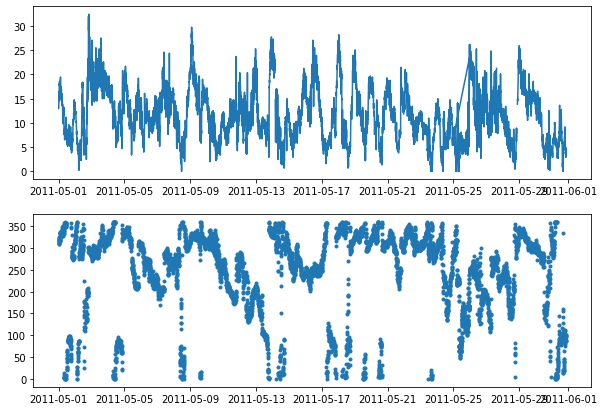

In [368]:
fix, ax = plt.subplots(2,1, figsize=(10,7))
ax[0].plot(wspd_month)
ax[1].plot(wdir_month,'.')

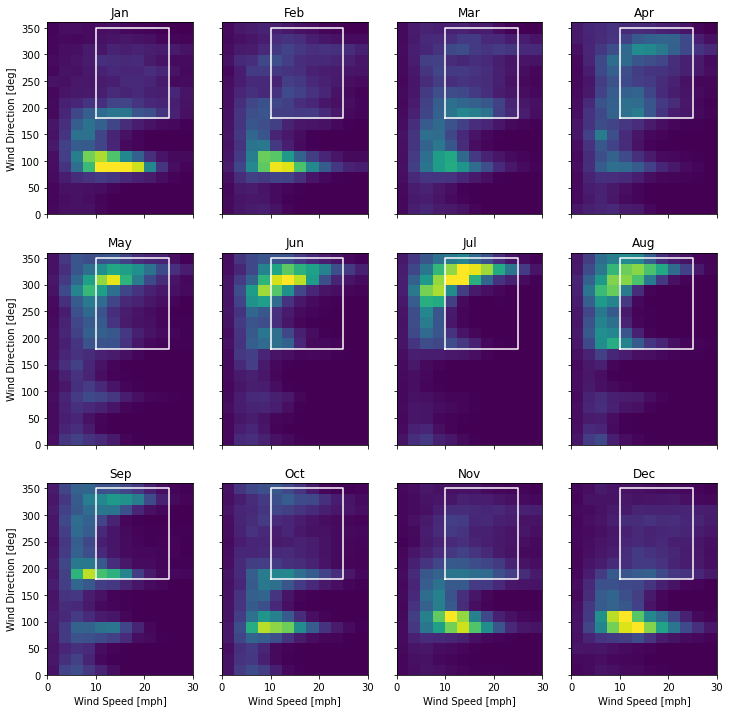

In [410]:
# Probability Distributions
fig, ax = plt.subplots(3, 4, figsize=(12,12), sharex=True, sharey=True)
ax = ax.ravel()

sbins = np.arange(0,32.5,2.5)
dbins = np.arange(0,380,20)
month_strs = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for i in np.arange(12):
    mon = i + 1
    I = wind.index.month == mon
    wspd_month = wind['spd'][I]
    wdir_month = wind['dir'][I]
    plt.sca(ax[i])
    plt.hist2d(wspd_month,wdir_month, bins=(sbins,dbins), density=True)
    plt.title(month_strs[i])
    plt.clim([0, .0008])
    plt.plot([10, 25, 25, 10, 10], [180, 180, 350, 350, 180], 'w')

ax[0].set_ylabel('Wind Direction [deg]')
ax[4].set_ylabel('Wind Direction [deg]')
ax[8].set_ylabel('Wind Direction [deg]')
ax[8].set_xlabel('Wind Speed [mph]')
ax[9].set_xlabel('Wind Speed [mph]')
ax[10].set_xlabel('Wind Speed [mph]')
ax[11].set_xlabel('Wind Speed [mph]')
plt.show()